# [Hands-On] Prompt-based Text Classification Using Large Language Models

- Author : Sangkeun Jung (hugmanskj@gmail.com)

> Educational Purpose

This lecture is a part of the classification explanation series, specifically focusing on **prompt-based** classification in natural language processing (NLP) tasks.

## What is Prompt-Based Classification?
Prompt-based classification utilizes prompts — small pieces of text — to instruct a pre-trained model on how to process and classify incoming data. For instance, by framing a question or adding a specific instruction to the input, the model uses this context to generate an appropriate response or classification. This method hinges on the model's ability to understand and respond to the prompts based on the training it has received.


In this notebook, we demonstrate an innovative approach to topic classification leveraging the capabilities of generative models. Unlike traditional head-based methods that rely on a fixed number of output classes, prompt-based learning formulates the task as a language generation problem.

This method involves constructing a prompt with a blank (e.g., "This is a story about ______"), where the model fills in the blank with contextually relevant words. Based on the generated text, we infer the topic or sentiment of the input.

## Objectives:
- Understand the concept of prompt-based classification with generative language models.
- Implement a topic classification model using large-language-model like GPT3.5 on the AG News dataset.
- Evaluate the model's ability to generate topic-relevant words and infer the correct topic from those words.

Let's dive into prompt-based topic classification!


In [1]:
!pip install -qq datasets
!pip install -qq openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 6.8 MB/s eta 0:00:00


## Load the Dataset

In [2]:
from datasets import load_dataset
import pandas as pd

# Load the AG News dataset from the Hugging Face 'datasets' library
dataset = load_dataset("ag_news")

# Preview the dataset structure
print(dataset)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})


In [3]:
# Map the prediction index to the class name (if you have a label map)
label_map = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}

## Set Up OpenAI API Key

To perform this tutorial, there are some prerequisites. You will need an OpenAI API key to proceed properly. If you already have one, please set your key below.

In this lecture, we have left the key field blank initially.

If you do not have an OpenAI API key, you can still proceed with the tutorial in two ways:

- The author has pre-generated the text for the prompts. You can enable `USE_GENERATED_DATA=True` in the below section and proceed.
- If you do not wish to use GPT-3.5, you can either use another cloud-based LLM service or connect a local instance of Open LLMs like LLaMA 3.


In [4]:
# !!!! NOTE
#USE_GENERATED_DATA = False  # <-- use GPT 3.5
USE_GENERATED_DATA = True    # <-- use pre-generated texts from GPT 3.5

## Prepare Prompts

In [5]:
# Function to add a prompt to the texts
def make_topic_cls_prompt(text):
    return f"Task : Topic Classification. Topic-class must be one of the (World, Sports, Business, Sci/Tech). The text is [{text}]. What is topic?"

In [6]:
def map_generated_to_topic(generated_text):
    generated_text = generated_text.lower()
    if "world" in generated_text:
        return "World"
    elif "sport" in generated_text:
        return "Sports"
    elif "business" in generated_text:
        return "Business"
    elif "sci" in generated_text:
        return "Sci/Tech"
    elif "technology" in generated_text:
        return "Sci/Tech"
    else:
        return "Unknown"

### Prepare GPT 3.5 and test sample

Define a function to send prompts to the GPT-3.5 model via the OpenAI API and receive the generated text.


In [7]:
if USE_GENERATED_DATA == False:
  import os
  # Replace 'your_openai_api_key' with your actual OpenAI API key
  os.environ["OPENAI_API_KEY"] = ""  # <--- set your OPENAI API KEY

  # -----
  from openai import OpenAI
  client = OpenAI()
  import json

  def query_to_gpt(text):
      response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
          {"role": "user", "content": f"{text}"}
        ]
      )
      return response.choices[0].message.content

  # ---
  sample_text = "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again."

  # Query GPT-3.5
  prompt = make_topic_cls_prompt(sample_text)
  generated_text = query_to_gpt(prompt)
  print("Generated text:", generated_text)

  # Prediction with generated text
  #    : Map the generated text to a topic
  predicted_topic = map_generated_to_topic(generated_text)
  print(f"Predicted Topic: {predicted_topic}")

### Predictions over test dataset

In [8]:
import requests
from datasets import Dataset

if USE_GENERATED_DATA == True:
  print("[Download] dataset download")
  url = 'https://www.dropbox.com/scl/fi/n7wappv0dbh6jta6ghfon/subset_dataset.json?rlkey=0lcqfndfcndn6vfsudthbrmmm&st=nli9kv1s&dl=1'

  # Download the file content
  response = requests.get(url)
  response.raise_for_status()  # Ensure the request was successful
  dataset_json = response.json()  # Convert the response to JSON

  # Convert JSON data to DataFrame
  df = pd.DataFrame(dataset_json)

  # Convert DataFrame to Hugging Face dataset
  subset_test_dataset = Dataset.from_pandas(df)
  print("Dataset loaded and converted to Hugging Face dataset format.")
else:
  subset_test_dataset = dataset['test'].select( range(100) ) # sample 100
  subset_test_dataset = subset_test_dataset.add_column("generated_text", ['']*len(subset_test_dataset))

[Download] dataset download
Dataset loaded and converted to Hugging Face dataset format.


In [9]:
subset_test_dataset

Dataset({
    features: ['text', 'label', 'generated_text', '__index_level_0__'],
    num_rows: 100
})

In [10]:
subset_test_dataset['generated_text'][:5]

['Business',
 'The topic is Sci/Tech.',
 'The topic of the text is Sci/Tech.',
 'The topic of the text is Sci/Tech, as it discusses the use of a prediction unit to forecast wildfires.',
 'The topic of the text is "Sci/Tech" (Science/Technology) as it discusses Southern California\'s efforts to reduce air pollution from dairy cow manure.']

In [11]:
import pandas as pd
from tqdm import tqdm
data = {'text':[], 'pred_label':[], 'ref_label':[], 'llm_answer':[]}

for text, ref_label, _gen in tqdm(zip(subset_test_dataset['text'],
                                      subset_test_dataset['label'],
                                      subset_test_dataset['generated_text']
                                      )):
    prompt = make_topic_cls_prompt(text)
    generated_text = _gen if USE_GENERATED_DATA else query_to_gpt(prompt)
    predicted_label = map_generated_to_topic(generated_text)

    data['text'].append(text)
    data['pred_label'].append(predicted_label)
    data['ref_label'].append(label_map[ref_label])
    data['llm_answer'].append(generated_text)

result_df = pd.DataFrame(data)

100it [00:00, 218226.01it/s]


In [12]:
result_df

,text,pred_label,ref_label,llm_answer
0,Fears for T N pension after talks Unions repre...,Business,Business,Business
1,The Race is On: Second Private Team Sets Launc...,Sci/Tech,Sci/Tech,The topic is Sci/Tech.
2,Ky. Company Wins Grant to Study Peptides (AP) ...,Sci/Tech,Sci/Tech,The topic of the text is Sci/Tech.
3,Prediction Unit Helps Forecast Wildfires (AP) ...,Sci/Tech,Sci/Tech,"The topic of the text is Sci/Tech, as it discu..."
4,Calif. Aims to Limit Farm-Related Smog (AP) AP...,Sci/Tech,Sci/Tech,"The topic of the text is ""Sci/Tech"" (Science/T..."
...,...,...,...,...
95,Eriksson doesn #39;t feel any extra pressure f...,Sports,Sports,The topic of the text is Sports.
96,Injured Heskey to miss England friendly NEWCAS...,Sports,Sports,Sports
97,"Staples Profit Up, to Enter China Market NEW ...",Business,Business,Business
98,Delegation Is Delayed Before Reaching Najaf AG...,World,World,The topic is World.


In [13]:
set( result_df.pred_label.values )

{'Business', 'Sci/Tech', 'Sports', 'Unknown', 'World'}

In [14]:
result_df[ result_df.pred_label == 'Unknown' ].llm_answer.values

array(['The topic of the text is "Entertainment" as it revolves around Michael Jackson and his court appearance for child molestation charges.',
       'The topic is Politics, specifically the 2004 presidential election in California between Democratic challenger John Kerry and President Bush.'],
      dtype=object)

> Note!!

- Originally, post-processing for unknown classification is necessary, but for simplicity in this case, we will map all unknown classes to 'World'.
- In the future, such issues could be resolved through sentence similarity, keyword similarity, or prompt engineering.

In [15]:
# Assign 'World' class to 'Unknown' classes
result_df.loc[result_df.pred_label == 'Unknown', 'pred_label'] = 'World'

In [16]:
result_df[result_df.pred_label == 'Unknown']

,text,pred_label,ref_label,llm_answer


## Calculate Evaluation Metrics

In [17]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

# Assuming result_df is your DataFrame and it's already defined

# Calculate metrics
accuracy = accuracy_score(result_df['ref_label'], result_df['pred_label'])
precision, recall, f1, _ = precision_recall_fscore_support(result_df['ref_label'], result_df['pred_label'], average='weighted')

# Create a DataFrame to display metrics
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score'],
    'Value': [accuracy, precision, recall, f1]
})

metrics_df.T

,0,1,2,3
Metric,Accuracy,Precision,Recall,F1-score
Value,0.79,0.875013,0.79,0.802883


## Plot the Confusion Matrix

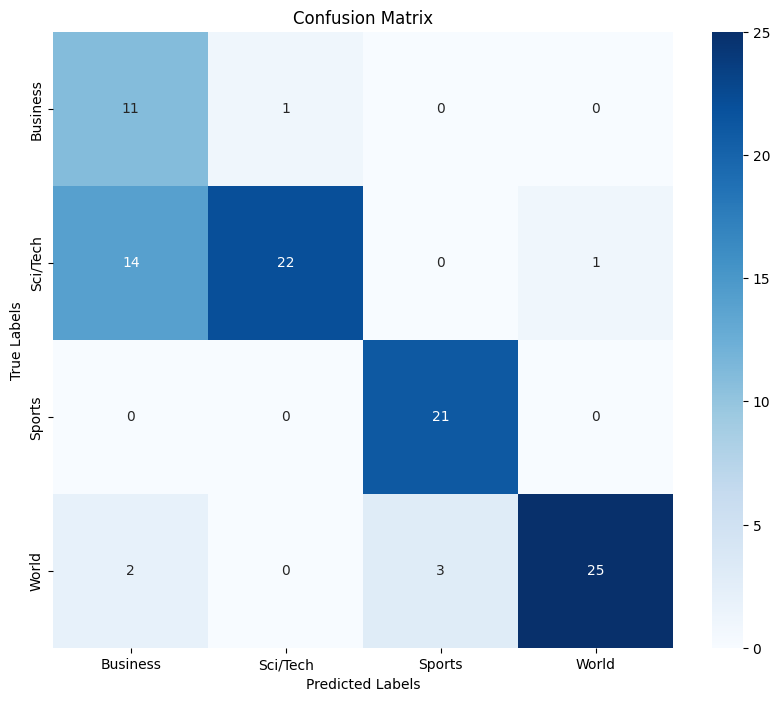

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(result_df['ref_label'], result_df['pred_label'])

# Get sorted unique labels
labels = sorted(result_df['ref_label'].unique())

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Conclusion

In this tutorial, we explored an approach to prompt-based classification using generative models. Prompt-based classification operates by utilizing prompts to instruct a pre-trained model to generate language that likely includes the most plausible class label when processing and classifying input data.

Unlike traditional head-based methods that rely on a fixed number of output classes, prompt-based learning treats the task as a language generation problem. This involves configuring the model to fill in blanks with contextually relevant words or to generate descriptors that correspond to classes, thereby solving classification problems.

This method offers the following advantages:
- It is not confined to fixed classification categories, allowing for the exploration of various response possibilities.
- It maximizes the model's ability to understand and generate natural language, providing a more dynamic and flexible method of classification that is not limited by a fixed number of classes or types.
- It does not require additional fine-tuning or parameters for classification.

Prompt-based classification is a relatively new technique that is gaining attention and holds boundless potential as a classification method for the future.
